In [6]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import scipy
from scipy.optimize import fminbound
from quantecon import compute_fixed_point

In [7]:
""" Problem 2 """

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)
    
lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

In [8]:
def bellman_operator1(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = 0.95*y   #we are provided an optimal c given y
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [9]:
def bellman_operator2(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = scipy.stats.lognorm.cdf(y, 0.5)*y
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [10]:
# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator1(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.289e+00      5.908e-02         
20           7.832e-01      1.027e-01         
30           5.110e-01      1.486e-01         
40           3.385e-01      1.949e-01         
50           2.248e-01      2.543e-01         
60           1.495e-01      3.048e-01         
70           9.937e-02      3.556e-01         
80           6.606e-02      4.062e-01         
90           4.392e-02      4.568e-01         
100          2.920e-02      5.239e-01         
110          1.941e-02      5.843e-01         
120          1.291e-02      6.489e-01         
130          8.580e-03      7.155e-01         
140          5.705e-03      7.830e-01         
150          3.793e-03      8.333e-01         
160          2.521e-03      8.781e-01         
170          1.676e-03      9.223e-01         
180          1.114e-03      9.671e-01         
190          7.409e-04      1.018e+00         
200          4.

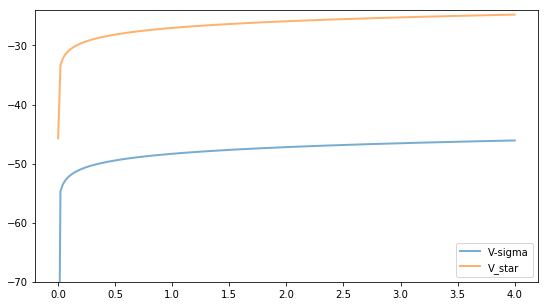

In [12]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-70, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='V-sigma')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='V_star')
ax.legend(loc='lower right')
plt.show()

In [13]:
# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator2(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           3.335e-01      2.943e-01         
20           2.217e-01      5.680e-01         
30           1.474e-01      9.215e-01         
40           9.800e-02      1.206e+00         
50           6.515e-02      1.475e+00         
60           4.332e-02      1.735e+00         
70           2.880e-02      1.999e+00         
80           1.915e-02      2.379e+00         
90           1.273e-02      2.720e+00         
100          8.463e-03      3.150e+00         
110          5.626e-03      3.450e+00         
120          3.740e-03      4.008e+00         
130          2.487e-03      4.442e+00         
140          1.653e-03      4.716e+00         
150          1.099e-03      5.057e+00         
160          7.308e-04      5.444e+00         
170          4.858e-04      5.705e+00         
180          3.230e-04      6.021e+00         
190          2.147e-04      6.499e+00         
200          1.

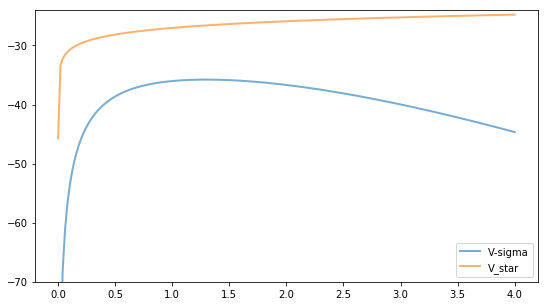

In [14]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-70, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='V-sigma')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='V_star')
ax.legend(loc='lower right')
plt.show()

In [15]:
""" 
We can easily see from both graphs that neither policy function is an optimal policy.
In both cases V_sigma is much smaller than V_star (which we can calculate analytically),
implying that neither one is optimal. In the first graph, V_sigma seems to be 
V_star shifted downwards, while in the second graph, V_sigma reaches a peak between 0.5 and 1
and then decreases, while V_star monotinically increases. 
"""

' \nWe can easily see from both graphs that neither policy function is an optimal policy.\nIn both cases V_sigma is much smaller than V_star (which we can calculate analytically),\nimplying that neither one is optimal. In the first graph, V_sigma seems to be \nV_star shifted downwards, while in the second graph, V_sigma reaches a peak between 0.5 and 1\nand then decreases, while V_star monotinically increases. \n'